Commercial banks receive _a lot_ of applications for credit cards. Many of them get rejected for many reasons, like high loan balances, low income levels, or too many inquiries on an individual's credit report, for example. Manually analyzing these applications is mundane, error-prone, and time-consuming (and time is money!). Luckily, this task can be automated with the power of machine learning and pretty much every commercial bank does so nowadays. In this notebook, we will build an automatic credit card approval predictor using machine learning techniques, just like real banks do.

![Credit card being held in hand](credit_card.jpg)

You have been provided with a small subset of the credit card applications a bank receives. The dataset has been loaded as a Pandas DataFrame for you. You will start from there. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

cc_apps = pd.read_csv("cc_approvals.data", header=None) 
cc_apps.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


[[103   0]
 [  0 125]]
Best: 1.000000 using {'max_iter': 100, 'tol': 0.01}
Accuracy of logistic regression classifier:  1.0
     Actual  Predicted
0         1          1
1         0          0
2         1          1
3         1          1
4         0          0
..      ...        ...
223       1          1
224       0          0
225       1          1
226       1          1
227       1          1

[228 rows x 2 columns]


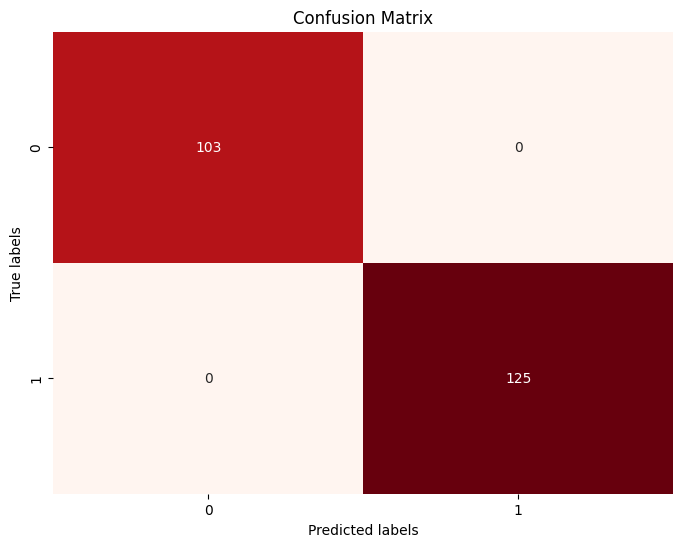

In [2]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns



cc_apps = pd.read_csv("cc_approvals.data", header=None)

cc_apps = cc_apps.drop([11, 13], axis=1)


cc_apps_train, cc_apps_test = train_test_split(cc_apps, test_size=0.33, random_state=42)

cc_apps_train_nans_replaced = cc_apps_train.replace("?", np.NaN)
cc_apps_test_nans_replaced = cc_apps_test.replace("?", np.NaN)

cc_apps_train_imputed = cc_apps_train_nans_replaced.fillna(cc_apps_train_nans_replaced.mean())
cc_apps_test_imputed = cc_apps_test_nans_replaced.fillna(cc_apps_train_nans_replaced.mean())

for col in cc_apps_train_imputed.columns:
    if cc_apps_train_imputed[col].dtypes == "object":

        cc_apps_train_imputed = cc_apps_train_imputed.fillna(
            cc_apps_train_imputed[col].value_counts().index[0] )
        
        cc_apps_test_imputed = cc_apps_test_imputed.fillna(
            cc_apps_train_imputed[col].value_counts().index[0])


cc_apps_train_cat_encoding = pd.get_dummies(cc_apps_train_imputed)
cc_apps_test_cat_encoding = pd.get_dummies(cc_apps_test_imputed)

cc_apps_test_cat_encoding = cc_apps_test_cat_encoding.reindex(
    columns=cc_apps_train_cat_encoding.columns, fill_value=0
)

X_train, y_train = (
    cc_apps_train_cat_encoding.iloc[:, :-1].values,
    cc_apps_train_cat_encoding.iloc[:, [-1]].values,
)
X_test, y_test = (
    cc_apps_test_cat_encoding.iloc[:, :-1].values,
    cc_apps_test_cat_encoding.iloc[:, [-1]].values,
)

scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX_train = scaler.fit_transform(X_train)
rescaledX_test = scaler.transform(X_test)


logreg = LogisticRegression()

logreg.fit(rescaledX_train, y_train)

y_pred = logreg.predict(rescaledX_test)

# ------------------Print the confusion matrix of the logreg model--------SABBAH-------
print(confusion_matrix(y_test, y_pred))


tol = [0.01, 0.001, 0.0001]
max_iter = [100, 150, 200]


param_grid = dict(tol=tol, max_iter=max_iter)

grid_model = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5)

grid_model_result = grid_model.fit(rescaledX_train, y_train)

best_score, best_params = grid_model_result.best_score_, grid_model_result.best_params_
print("Best: %f using %s" % (best_score, best_params))

best_model = grid_model_result.best_estimator_
print(
    "Accuracy of logistic regression classifier: ",
    best_model.score(rescaledX_test, y_test),
)
cm = confusion_matrix(y_test, y_pred)

# ----------Convert confusion matrix to DataFrame for comparison---------------
comparison_df = pd.DataFrame(data={
    'Actual': y_test.flatten(),
    'Predicted': y_pred.flatten()
})

print(comparison_df)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()